In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

with open('./data/CESM2_pacific_SST.pkl', 'rb') as file:
    data = pickle.load(file)
data.shape

(6000, 24749)

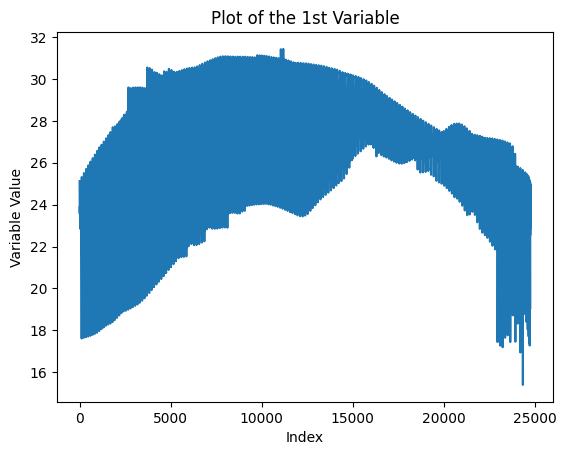

In [8]:
plt.plot(data[0, :]) # Change 0 to other indexes if you want to plot a different variable
plt.xlabel('Index')
plt.ylabel('Variable Value')
plt.title('Plot variables of the t=1')
plt.show()

In [12]:
from sklearn.cluster import KMeans
import numpy as np
# Define the number of clusters
num_clusters = 5

data_point = data[0, :].reshape(-1, 1)

# Initialize the K-means clustering algorithm
kmeans = KMeans(n_clusters=num_clusters)

# Fit the algorithm to the data
kmeans.fit(data_point)

# Predict the cluster labels for each data point
labels = kmeans.labels_

# Access the cluster centroids
centroids = kmeans.cluster_centers_

# Print the cluster labels and centroids
for i in range(num_clusters):
    cluster_points = data_point[labels == i]
    print(f"Cluster {i+1} - Size: {cluster_points.shape[0]}")
    print(f"Centroid: {centroids[i]}")
    print()

# You can also access other attributes such as 'kmeans.inertia_' which represents the sum of squared distances to the closest centroid

/home/minghao.fu/workspace/fmh_conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 1 - Size: 6019
Centroid: [25.736954]

Cluster 2 - Size: 6045
Centroid: [29.704573]

Cluster 3 - Size: 4252
Centroid: [23.661005]

Cluster 4 - Size: 2158
Centroid: [20.432758]

Cluster 5 - Size: 6275
Centroid: [27.465332]



In [22]:
predictions = np.load('./results/good3/epoch_20000/prediction.npy')
print(predictions[0])

[[ 0.     -0.0582  0.1105  0.      0.    ]
 [ 0.      0.      0.     -0.097   0.    ]
 [-0.0396  0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.     -0.1961  0.    ]]


In [23]:
def gaussian_log_likelihood(S, theta):
    n = theta.shape
    log_det_cov = np.log(np.linalg.det(theta))
    inv_cov_matrix = np.linalg.inv(S)
    diff = theta - L
    log_likelihood = -0.5 * N * np.log(2 * np.pi) - 0.5 * log_det_cov - 0.5 * np.sum(diff @ inv_cov_matrix * diff)
    
    return log_likelihood

In [24]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data = scaler.fit_transform(data)
print(data.shape, np.mean(data), np.var(data))

# Initialize Factor Analysis model with the number of components you want
n_components = 50  # You can adjust this value based on your needs
fa = FactorAnalysis(n_components=n_components)

# Fit the model
fa.fit(data)

# Transformed data
data_transformed = fa.transform(data)

# Factor loadings (shape will be (26500, n_components))
loadings = fa.components_


(6000, 24749) 1.1001094e-10 0.99999785


In [25]:
import torch
import torch.optim as optim
import numpy as np
from utils import check_tensor
from LatentTimeVaryingCausalDiscovery.data import synthetic_data

theta = torch.randn(5, 5, requires_grad=True)
L = torch.randn(5, 5, requires_grad=True)
predictions = np.load('./results/good3/epoch_20000/prediction.npy')
S = check_tensor(predictions)



ModuleNotFoundError: No module named 'LatentTimeVaryingCausalDiscovery'

In [ ]:


alpha = 0.01
tau = 0.01
optimizer = optim.SGD([theta, L], lr=1e-3)


def off_diag_l1_norm(matrix):
    off_diag = matrix - torch.diag_embed(torch.diag(matrix))
    return torch.sum(torch.abs(off_diag))

def nuclear_norm(matrix):
    return torch.sum(torch.svd(matrix).S)

for epoch in range(20000):
    optimizer.zero_grad()
    loss = torch.norm(S - theta + L) + alpha * off_diag_l1_norm(theta) + tau * nuclear_norm(L) + 0.1*torch.norm(theta, p=1) + 0.1*torch.norm(L, p=1)
    loss.backward()
    optimizer.step()
    # new = theta.clone()
    # new[torch.abs(theta) < 1e-6] = 0
    # theta = new
    
    if epoch % 10000 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')

print("S:", S)
print("theta:", theta)
print("L:", L)
print("theta - L:", theta - L)


Epoch 0, Loss 412.7169494628906
Epoch 10000, Loss 43.14106750488281
S: tensor([[[ 0.0000, -0.0582,  0.1105,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -0.0970,  0.0000],
         [-0.0396,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -0.1961,  0.0000]],

        [[ 0.0000, -0.0526,  0.1255,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -0.0785,  0.0000],
         [-0.0412,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.5880, -0.1431,  0.0000]],

        [[ 0.0000, -0.0256,  0.1245,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0572,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.0158,  0.0231,  0.0000]],

        ...,

        [[ 0.0000,  0.2474,  0.2529,  0.0000,  0.0000],
         [ 0.

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Number of nodes
n = 10

# Create an empty graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(range(n))

# Add edges to make a chain
for i in range(n-1):
    G.add_edge(i, i+1)

# Draw the graph
plt.show()


In [2]:
import networkx as nx

# Create Graph objects for the two graphs
graph1 = nx.DiGraph()
graph2 = nx.DiGraph()

# Add edges to the graphs (representing the structural relationships)
graph1.add_edges_from([(0, 1), (1, 2), (2, 0)])
graph2.add_edges_from([(0, 1), (1, 2), (2, 3)])

# Check if the graphs are isomorphic (structurally equivalent)
isomorphic = nx.is_isomorphic(graph1, graph2)

if isomorphic:
    print("The graphs are structurally equivalent.")
else:
    print("The graphs are not structurally equivalent.")


The graphs are not structurally equivalent.


In [ ]:
def cal_mse_loss(x, y):
    return np.mean(np.abs(x - y))

def log_gaussian_likelihood(X, mu, sigma):
    n = X.shape[0]
    log_det_cov = np.log(np.linalg.det(sigma))
    inv_cov_matrix = np.linalg.inv(sigma)
    diff = X - mu
    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * log_det_cov - 0.5 * np.sum(diff @ inv_cov_matrix * diff)
    
    return log_likelihood